In [1]:
!nvidia-smi


Sat Dec  6 13:22:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!cp -r /content/drive/MyDrive/brain_tumor_/dataset/archive_data_brain_tumor /content/data


In [4]:
BASE_PATH = "/content/data/BT_MRI_Dataset/BT_MRI_Dataset"
TRAIN_DIR = BASE_PATH + "/Training"
TEST_DIR  = BASE_PATH + "/Testing"


In [5]:
IMG_SIZE = 240
BATCH_SIZE = 16          # smaller = faster + stable gradients
NUM_CLASSES = 4
SEED = 42


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input


In [8]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [9]:
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical',
    subset='training', shuffle=True, seed=SEED
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical',
    subset='validation', shuffle=False, seed=SEED
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical',
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [10]:
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras import Model


In [11]:


def build_model():
    base = EfficientNetB2(weights="imagenet", include_top=False,
                          input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))
    base.trainable = False   # frozen for stage-1

    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.2)(x)
    out = Dense(NUM_CLASSES, activation="softmax")(x)

    return Model(inputs=base.input, outputs=out), base

model, base_model = build_model()
model.summary()


31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 240, 240,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 240, 240,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 240, 240,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 241, 241,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 120, 120,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 120, 120,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 120, 120,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 120, 120,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 120, 120,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 120, 120,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 120, 120,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 120, 120,  │        512 │ block1a_se_excit

 Total params: 7,774,205 (29.66 MB)

 Trainable params: 5,636 (22.02 KB)

 Non-trainable params: 7,768,569 (29.63 MB)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=5, verbose=1),
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
]


In [14]:
history1 = model.fit(
    train_gen, validation_data=val_gen,
    epochs=10,
    callbacks=callbacks,
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.6813 - loss: 0.8049

286/286 ━━━━━━━━━━━━━━━━━━━━ 163s 425ms/step - accuracy: 0.6817 - loss: 0.8042 - val_accuracy: 0.7730 - val_loss: 0.5514 - learning_rate: 0.0010
Epoch 2/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.8599 - loss: 0.3988

286/286 ━━━━━━━━━━━━━━━━━━━━ 77s 269ms/step - accuracy: 0.8600 - loss: 0.3987 - val_accuracy: 0.8081 - val_loss: 0.4527 - learning_rate: 0.0010
Epoch 3/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8825 - loss: 0.3426

286/286 ━━━━━━━━━━━━━━━━━━━━ 77s 268ms/step - accuracy: 0.8825 - loss: 0.3425 - val_accuracy: 0.8309 - val_loss: 0.4249 - learning_rate: 0.0010
Epoch 4/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9017 - loss: 0.2993

286/286 ━━━━━━━━━━━━━━━━━━━━ 75s 261ms/step - accuracy: 0.9017 - loss: 0.2993 - val_accuracy: 0.8536 - val_loss: 0.3832 - learning_rate: 0.0010
Epoch 5/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 76s 266ms/step - accuracy: 0.8930 - loss: 0.2910 - val_accuracy: 0.8317 - val_loss: 0.3913 - learning_rate: 0.0010
Epoch 6/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 76s 266ms/step - accuracy: 0.9142 - loss: 0.2546 - val_accuracy: 0.8431 - val_loss: 0.4054 - learning_rate: 0.0010
Epoch 7/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 77s 268ms/step - accuracy: 0.9220 - loss: 0.2329 - val_accuracy: 0.8519 - val_loss: 0.4158 - learning_rate: 0.0010
Epoch 8/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.9148 - loss: 0.2426

286/286 ━━━━━━━━━━━━━━━━━━━━ 76s 265ms/step - accuracy: 0.9148 - loss: 0.2425 - val_accuracy: 0.8615 - val_loss: 0.3486 - learning_rate: 0.0010
Epoch 9/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 76s 266ms/step - accuracy: 0.9167 - loss: 0.2250 - val_accuracy: 0.8642 - val_loss: 0.3627 - learning_rate: 0.0010
Epoch 10/10
286/286 ━━━━━━━━━━━━━━━━━━━━ 76s 267ms/step - accuracy: 0.9134 - loss: 0.2506 - val_accuracy: 0.8624 - val_loss: 0.3880 - learning_rate: 0.0010


In [15]:
for layer in base_model.layers:
    layer.trainable = True


In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [17]:
history2 = model.fit(
    train_gen, validation_data=val_gen,
    epochs=40,
    callbacks=callbacks
)


Epoch 1/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 256s 533ms/step - accuracy: 0.8403 - loss: 0.5211 - val_accuracy: 0.8273 - val_loss: 0.4995 - learning_rate: 0.0010
Epoch 2/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 84s 293ms/step - accuracy: 0.9405 - loss: 0.1767 - val_accuracy: 0.8291 - val_loss: 0.5825 - learning_rate: 0.0010
Epoch 3/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 84s 292ms/step - accuracy: 0.9469 - loss: 0.1512 - val_accuracy: 0.8317 - val_loss: 0.7189 - learning_rate: 0.0010
Epoch 4/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9701 - loss: 0.0883

286/286 ━━━━━━━━━━━━━━━━━━━━ 85s 298ms/step - accuracy: 0.9701 - loss: 0.0883 - val_accuracy: 0.9150 - val_loss: 0.2386 - learning_rate: 0.0010
Epoch 5/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 83s 291ms/step - accuracy: 0.9761 - loss: 0.0769 - val_accuracy: 0.9220 - val_loss: 0.2986 - learning_rate: 0.0010
Epoch 6/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 83s 291ms/step - accuracy: 0.9825 - loss: 0.0546 - val_accuracy: 0.9194 - val_loss: 0.3020 - learning_rate: 0.0010
Epoch 7/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 84s 293ms/step - accuracy: 0.9801 - loss: 0.0591 - val_accuracy: 0.9167 - val_loss: 0.3667 - learning_rate: 0.0010
Epoch 8/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 83s 291ms/step - accuracy: 0.9912 - loss: 0.0280 - val_accuracy: 0.9264 - val_loss: 0.3180 - learning_rate: 0.0010
Epoch 9/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9754 - loss: 0.0647
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
286/286 ━━━━━━━━━━━━━━━━━━━━ 83s 289ms/step - accuracy: 0.9755 - loss: 0

286/286 ━━━━━━━━━━━━━━━━━━━━ 84s 293ms/step - accuracy: 0.9913 - loss: 0.0270 - val_accuracy: 0.9509 - val_loss: 0.1842 - learning_rate: 3.0000e-04
Epoch 11/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 84s 294ms/step - accuracy: 0.9972 - loss: 0.0087 - val_accuracy: 0.9457 - val_loss: 0.2023 - learning_rate: 3.0000e-04
Epoch 12/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9972 - loss: 0.0078

286/286 ━━━━━━━━━━━━━━━━━━━━ 84s 292ms/step - accuracy: 0.9972 - loss: 0.0078 - val_accuracy: 0.9492 - val_loss: 0.1769 - learning_rate: 3.0000e-04
Epoch 13/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9978 - loss: 0.0070

286/286 ━━━━━━━━━━━━━━━━━━━━ 84s 292ms/step - accuracy: 0.9978 - loss: 0.0070 - val_accuracy: 0.9527 - val_loss: 0.1668 - learning_rate: 3.0000e-04
Epoch 14/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9991 - loss: 0.0033

286/286 ━━━━━━━━━━━━━━━━━━━━ 86s 299ms/step - accuracy: 0.9991 - loss: 0.0033 - val_accuracy: 0.9579 - val_loss: 0.1657 - learning_rate: 3.0000e-04
Epoch 15/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9997 - loss: 0.0020

286/286 ━━━━━━━━━━━━━━━━━━━━ 84s 292ms/step - accuracy: 0.9997 - loss: 0.0020 - val_accuracy: 0.9509 - val_loss: 0.1638 - learning_rate: 3.0000e-04
Epoch 16/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 83s 289ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9553 - val_loss: 0.1751 - learning_rate: 3.0000e-04
Epoch 17/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 83s 291ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9527 - val_loss: 0.2158 - learning_rate: 3.0000e-04
Epoch 18/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 83s 290ms/step - accuracy: 1.0000 - loss: 4.9320e-04 - val_accuracy: 0.9544 - val_loss: 0.2046 - learning_rate: 3.0000e-04
Epoch 19/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 82s 288ms/step - accuracy: 1.0000 - loss: 3.3436e-04 - val_accuracy: 0.9597 - val_loss: 0.2310 - learning_rate: 3.0000e-04
Epoch 20/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 1.0000 - loss: 2.7401e-04
Epoch 20: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
286/286 ━━━━━━━━━━━━━━━━━━━━ 93s 3

286/286 ━━━━━━━━━━━━━━━━━━━━ 85s 297ms/step - accuracy: 0.9980 - loss: 0.0043 - val_accuracy: 0.9720 - val_loss: 0.1324 - learning_rate: 9.0000e-05
Epoch 22/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 84s 293ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9641 - val_loss: 0.1573 - learning_rate: 9.0000e-05
Epoch 23/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 83s 290ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.9606 - val_loss: 0.1654 - learning_rate: 9.0000e-05
Epoch 24/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 83s 290ms/step - accuracy: 0.9994 - loss: 0.0012 - val_accuracy: 0.9588 - val_loss: 0.1542 - learning_rate: 9.0000e-05
Epoch 25/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 84s 292ms/step - accuracy: 1.0000 - loss: 2.9726e-04 - val_accuracy: 0.9606 - val_loss: 0.1503 - learning_rate: 9.0000e-05
Epoch 26/40
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9999 - loss: 5.2656e-04
Epoch 26: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
286/286 ━━━━━━━━━━━━━━━━━━━━ 82s 288ms

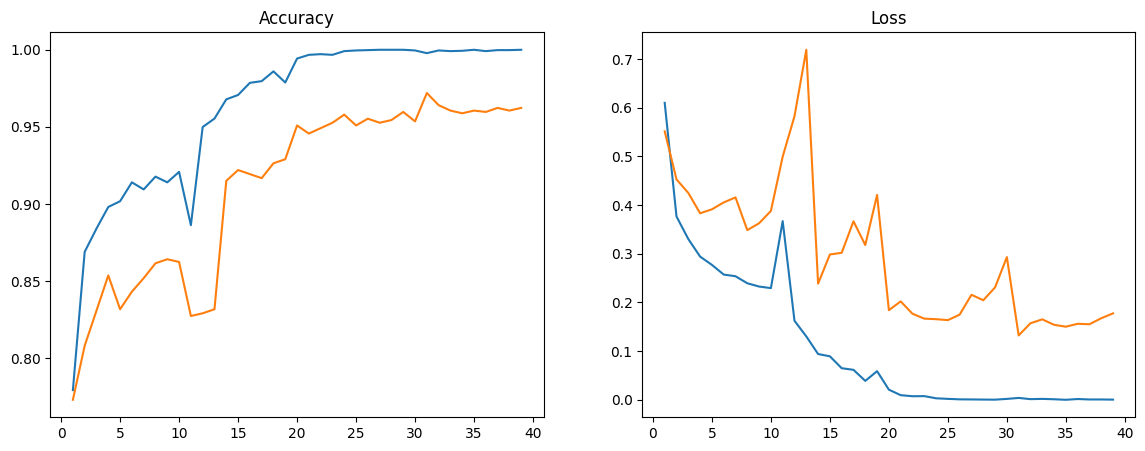

In [18]:
def plot_hist(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title("Loss")

    plt.show()

plot_hist(history1, history2)


In [19]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)


82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 207ms/step - accuracy: 0.9875 - loss: 0.0679
Test Accuracy: 0.9885583519935608


In [1]:
import matplotlib.pyplot as plt

def merge_histories(*histories):
    """Merge multiple Keras History objects into one dictionary."""
    merged = {}
    keys = histories[0].history.keys()

    for key in keys:
        merged[key] = []
        for h in histories:
            merged[key] += h.history[key]      # concatenate lists

    return merged


def plot_history(merged_hist):
    """Plot accuracy and loss for merged history."""
    acc = merged_hist['accuracy']
    val_acc = merged_hist['val_accuracy']
    loss = merged_hist['loss']
    val_loss = merged_hist['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title("Accuracy", fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title("Loss", fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()

    plt.tight_layout()
    plt.show()


# -------- RUN IT ----------
merged_hist = merge_histories(history1, history2)
plot_history(merged_hist)


NameError: name 'history1' is not defined

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = np.argmax(model.predict(test_gen), axis=1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true, y_pred))


82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       300
           1       0.98      0.97      0.98       306
           2       1.00      1.00      1.00       405
           3       1.00      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311

[[296   4   0   0]
 [  7 298   0   1]
 [  0   0 405   0]
 [  1   2   0 297]]


In [21]:
model.save("/content/drive/MyDrive/brain_tumor_model/final_effnetb2.h5")


In [22]:
# ------------------------------------------
# GRAD-CAM IMPLEMENTATION FOR EFFICIENTNET-B2
# ------------------------------------------

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input

# -------------------------------
# 1. FUNCTION TO GENERATE HEATMAP
# -------------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="top_conv", pred_index=None):

    # Build a model that maps input image → activations of last conv layer + predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute gradient of selected class wrt conv layer output
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        output_class = predictions[:, pred_index]

    # Gradients wrt conv layer output
    grads = tape.gradient(output_class, conv_outputs)

    # Global average pooling on gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight the output feature map by pooled gradients
    conv_outputs = conv_outputs[0]
    heatmap = tf.squeeze(tf.tensordot(conv_outputs, pooled_grads, axes=(2, 0)))

    # Normalize heatmap to 0–1
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()


# -----------------------------------------------------
# 2. FUNCTION TO PLOT ORIGINAL IMAGE + HEATMAP OVERLAY
# -----------------------------------------------------
def display_gradcam(img_path, model, img_size=240):
    # Read original image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize for model
    img_resized = cv2.resize(img_rgb, (img_size, img_size))

    # Preprocess for EfficientNet
    x = np.expand_dims(img_resized.astype(np.float32), axis=0)
    x = preprocess_input(x)

    # Model prediction
    preds = model.predict(x)
    pred_class = np.argmax(preds[0])

    # Generate heatmap
    heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name="top_conv")

    # Resize heatmap to image size
    heatmap = cv2.resize(heatmap, (img_rgb.shape[1], img_rgb.shape[0]))

    # Convert to color map
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap on original MRI
    overlay = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)

    # Plot results
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img_rgb)
    plt.title("Original MRI")
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM\nPredicted: {pred_class}")
    plt.axis('off')

    plt.show()

    return pred_class
